In [1]:
import os

# Create folder named 'images_to_stitch'
os.makedirs('images_to_stitch', exist_ok=True)
print("Folder 'images_to_stitch' created.")

Folder 'images_to_stitch' created.


In [3]:
from google.colab import files

# Upload files (for stitching or noisy image)
uploaded = files.upload()  # You’ll be prompted to upload files

Saving Screenshot 2025-04-24 164052.png to Screenshot 2025-04-24 164052.png
Saving Screenshot 2025-04-24 164110.png to Screenshot 2025-04-24 164110.png


In [4]:
import shutil

# Move uploaded files to the folder
shutil.move('left.png', 'images_to_stitch/left.png')
shutil.move('right.png', 'images_to_stitch/right.png')

uploaded = files.upload()

Saving Screenshot 2025-04-24 164052.png to Screenshot 2025-04-24 164052.png
Saving Screenshot 2025-04-24 164110.png to Screenshot 2025-04-24 164110.png


In [7]:
import cv2
import matplotlib.pyplot as plt

# Load image using OpenCV (replace with your actual image file)
# Check if the files exist before loading
import os

if os.path.exists('/content/left.jpg.png'):
    img1 = cv2.imread('/content/left.jpg.png', cv2.IMREAD_COLOR)  # Load in color
else:
    print("Error: '/content/left.jpg.png' not found.")
    img1 = None  # Or handle the error in a way that works for you

if os.path.exists('/content/noisy_image.jpg.png'):
    img2 = cv2.imread('/content/noisy_image.jpg.png', cv2.IMREAD_COLOR)  # Load in color
else:
    print("Error: '/content/noisy_image.jpg.png' not found.")
    img2 = None  # Or handle the error in a way that works for you

# Check if images were loaded correctly
if img1 is not None and img2 is not None:
    # Convert BGR (OpenCV) to RGB (matplotlib)
    img_rgb1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img_rgb2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    # Display the images
    plt.figure(figsize=(8, 6))
    plt.imshow(img_rgb1)
    plt.title("Displayed Image (img1)")
    plt.axis('off')
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.imshow(img_rgb2)
    plt.title("Displayed Image (img2)")
    plt.axis('off')
    plt.show()
else:
    print("Error: Could not load one or both images.")

Error: '/content/left.jpg.png' not found.
Error: '/content/noisy_image.jpg.png' not found.
Error: Could not load one or both images.


In [ ]:
!pip install opencv-python opencv-python-headless numpy

In [ ]:
import cv2

img1 = cv2.imread('image1.png')
img2 = cv2.imread('image2.png')

In [ ]:
def detect_and_match_features(img1, img2):
    orb = cv2.ORB_create()
    keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)
    matches = sorted(matches, key=lambda x: x.distance)

    return keypoints1, keypoints2, matches

keypoints1, keypoints2, matches = detect_and_match_features(img1, img2)

In [ ]:
def estimate_homography(keypoints1, keypoints2, matches, threshold=3):
    src_points = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_points = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    H, mask = cv2.findHomography(src_points, dst_points, cv2.RANSAC, threshold)
    return H, mask

H, mask = estimate_homography(keypoints1, keypoints2, matches)

In [ ]:
def warp_images(img1, img2, H):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    corners1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    corners2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
    warped_corners2 = cv2.perspectiveTransform(corners2, H)

    corners = np.concatenate((corners1, warped_corners2), axis=0)
    [xmin, ymin] = np.int32(corners.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(corners.max(axis=0).ravel() + 0.5)

    t = [-xmin, -ymin]
    Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])

    warped_img2 = cv2.warpPerspective(img2, Ht @ H, (xmax - xmin, ymax - ymin))
    warped_img2[t[1]:h1 + t[1], t[0]:w1 + t[0]] = img1

    return warped_img2

warped_img = warp_images(img1, img2, H)

In [ ]:
def blend_images(img1, img2):
    mask = np.where(img1 != 0, 1, 0).astype(np.float32)
    blended_img = img1 * mask + img2 * (1 - mask)
    return blended_img.astype(np.uint8)

output_img = blend_images(warped_img, img1)

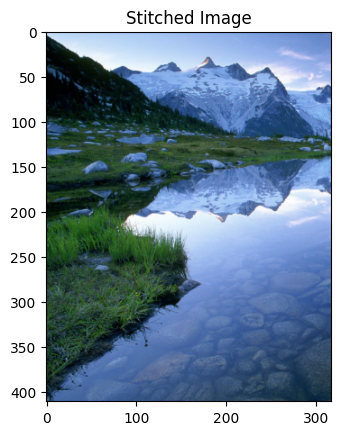

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)) # Convert from BGR to RGB for plt.imshow
plt.title('Stitched Image')
plt.show()
cv2.waitKey(0)
cv2.destroyAllWindows()

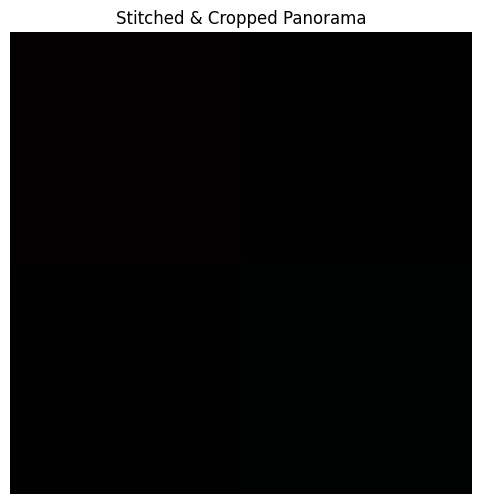

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load images
img1 = cv2.imread("image1.png")  # Replace with your filename
img2 = cv2.imread("image2.png")  # Replace with your filename

# Convert to grayscale
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# ORB detector
orb = cv2.ORB_create(5000)
kp1, des1 = orb.detectAndCompute(gray1, None)
kp2, des2 = orb.detectAndCompute(gray2, None)

# Matcher (with cross-check)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

# Homography
pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])
H, _ = cv2.findHomography(pts2, pts1, cv2.RANSAC)

# Warp second image to first
height1, width1 = img1.shape[:2]
height2, width2 = img2.shape[:2]
panorama = cv2.warpPerspective(img2, H, (width1 + width2, max(height1, height2)))
panorama[0:height1, 0:width1] = img1

# Crop black regions automatically
def crop_black(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        x, y, w, h = cv2.boundingRect(contours[0])
        return img[y:y+h, x:x+w]
    return img

cropped_panorama = crop_black(panorama)

# Convert to RGB for matplotlib
result_rgb = cv2.cvtColor(cropped_panorama, cv2.COLOR_BGR2RGB)

# Display
plt.figure(figsize=(14, 6))
plt.imshow(result_rgb)
plt.title("Stitched & Cropped Panorama")
plt.axis('off')
plt.show()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


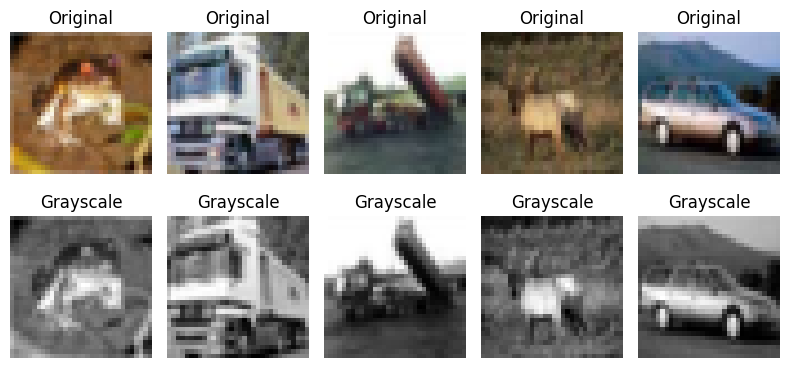

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.utils import plot_model

# Load CIFAR-10
(x_train, _), (x_test, _) = cifar10.load_data()

# Normalize pixel values between [0, 1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Resize: already 32x32, no resizing needed

# Convert to grayscale (optional)
def rgb2gray(images):
    return np.dot(images[...,:3], [0.2989, 0.5870, 0.1140])[..., np.newaxis]

x_train_gray = rgb2gray(x_train)
x_test_gray = rgb2gray(x_test)

# Display original and grayscale samples
plt.figure(figsize=(8, 4))
for i in range(5):
    # Original
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i])
    plt.title("Original")
    plt.axis('off')

    # Grayscale
    plt.subplot(2, 5, i+6)
    plt.imshow(x_train_gray[i].squeeze(), cmap='gray')
    plt.title("Grayscale")
    plt.axis('off')

plt.tight_layout()
plt.show()

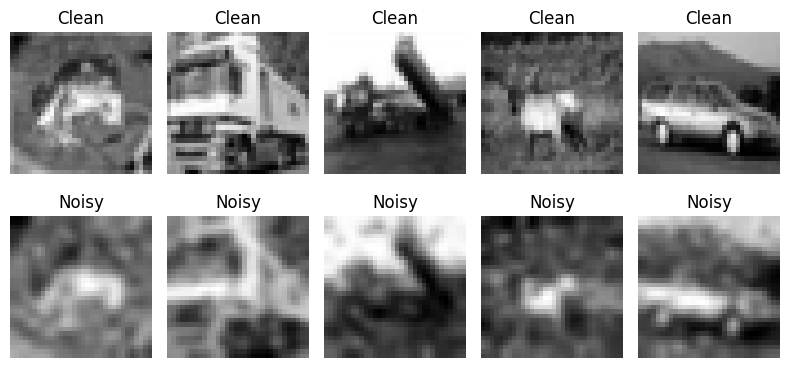

In [ ]:
import cv2
import random

# --- Gaussian Noise ---
def add_gaussian_noise(images, mean=0.0, std=0.1):
    noise = np.random.normal(mean, std, images.shape)
    noisy = images + noise
    return np.clip(noisy, 0., 1.)

# --- Salt & Pepper Noise ---
def add_salt_pepper_noise(images, amount=0.05):
    noisy_images = []
    for img in images:
        noisy = img.copy()
        num_salt = np.ceil(amount * img.size * 0.5)
        num_pepper = np.ceil(amount * img.size * 0.5)

        # Salt noise
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in img.shape[:2]]
        # Create a tuple of coordinates with the channel dimension as a slice
        coords_with_channel = tuple(coords + [slice(None)])
        noisy[coords_with_channel] = 1

        # Pepper noise (similar change as for salt noise)
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in img.shape[:2]]
        coords_with_channel = tuple(coords + [slice(None)])
        noisy[coords_with_channel] = 0

        noisy_images.append(noisy)
    return np.array(noisy_images)

# --- Gaussian Blur ---
def apply_gaussian_blur(images, ksize=(5, 5)):
    blurred = [cv2.GaussianBlur(img, ksize, 0) for img in images]
    return np.array(blurred)

# Simulate degradation
x_train_noisy = add_gaussian_noise(x_train_gray)
x_train_noisy = add_salt_pepper_noise(x_train_noisy)
x_train_noisy = apply_gaussian_blur(x_train_noisy)

x_test_noisy = add_gaussian_noise(x_test_gray)
x_test_noisy = add_salt_pepper_noise(x_test_noisy)
x_test_noisy = apply_gaussian_blur(x_test_noisy)

# Visualize degraded vs original
plt.figure(figsize=(8, 4))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train_gray[i].squeeze(), cmap='gray')
    plt.title("Clean")
    plt.axis('off')

    plt.subplot(2, 5, i+6)
    plt.imshow(x_train_noisy[i].squeeze(), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

# Input shape (grayscale): 32x32x1
input_img = Input(shape=(32, 32, 1))

# --- Encoder ---
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)  # 16x16

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)  # 8x8

# --- Decoder ---
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)  # 16x16

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)  # 32x32

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Define autoencoder
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

# Recompile the autoencoder with MSE loss
autoencoder.compile(optimizer=Adam(), loss=MeanSquaredError())

# Train the model
history = autoencoder.fit(
    x_train_noisy, x_train_gray,
    epochs=20,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test_gray)
)

Epoch 1/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 252s 635ms/step - loss: 0.0181 - val_loss: 0.0070
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 266s 646ms/step - loss: 0.0068 - val_loss: 0.0063
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 260s 643ms/step - loss: 0.0062 - val_loss: 0.0060
Epoch 4/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 257s 629ms/step - loss: 0.0060 - val_loss: 0.0058
Epoch 5/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 258s 621ms/step - loss: 0.0058 - val_loss: 0.0057
Epoch 6/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 235s 601ms/step - loss: 0.0057 - val_loss: 0.0056
Epoch 7/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 274s 632ms/step - loss: 0.0056 - val_loss: 0.0055
Epoch 8/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 250s 602ms/step - loss: 0.0055 - val_loss: 0.0056
Epoch 9/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 264s 606ms/step - loss: 0.0055 - val_loss: 0.0056
Epoch 10/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 272s 632ms/step - loss: 0.0054 - val_loss: 0.0053
Epoch 11/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 262s 633ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 12

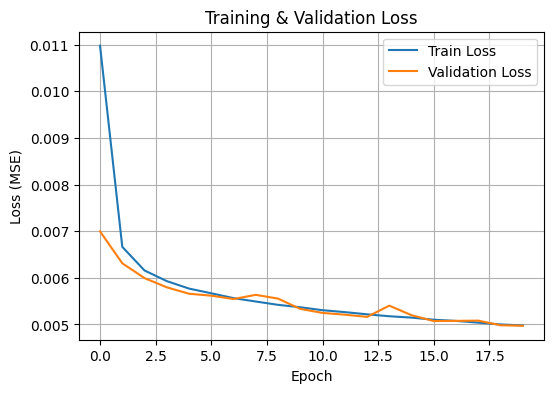

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step


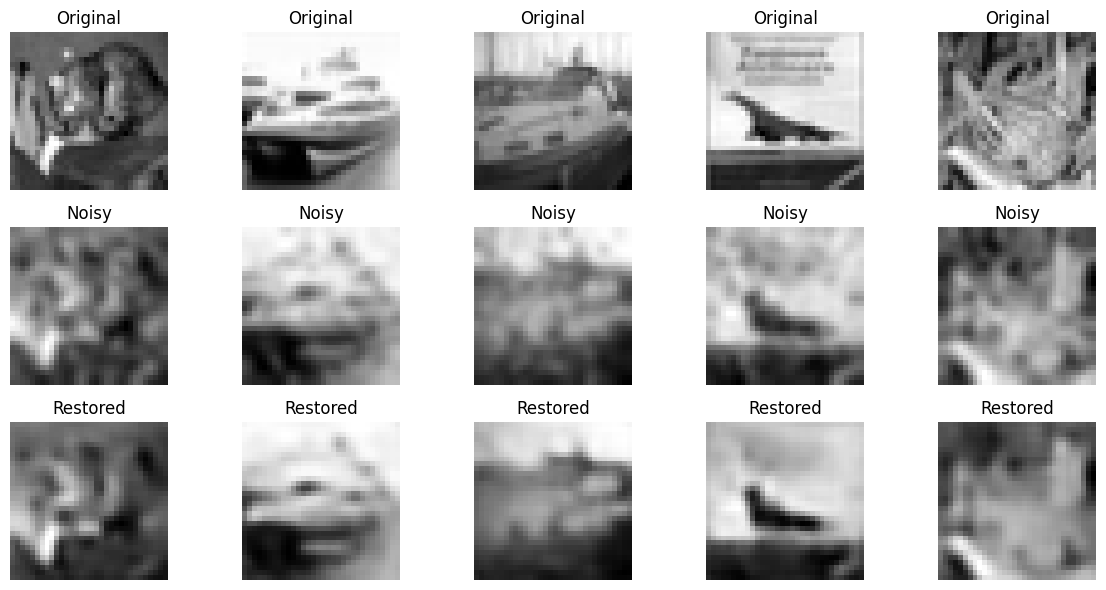

In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr

# Predict on test set
restored_images = autoencoder.predict(x_test_noisy)

# Visualize comparison for a few samples
num_images = 5
plt.figure(figsize=(12, 6))
for i in range(num_images):
    # Original
    plt.subplot(3, num_images, i + 1)
    plt.imshow(x_test_gray[i].squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Noisy
    plt.subplot(3, num_images, i + 1 + num_images)
    plt.imshow(x_test_noisy[i].squeeze(), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')

    # Restored
    plt.subplot(3, num_images, i + 1 + 2 * num_images)
    plt.imshow(restored_images[i].squeeze(), cmap='gray')
    plt.title("Restored")
    plt.axis('off')

plt.tight_layout()
plt.show()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50 | Generator Loss: 1.0326 | Discriminator Loss: 1.2403
Epoch 2/50 | Generator Loss: 0.7648 | Discriminator Loss: 1.5099
Epoch 3/50 | Generator Loss: 0.7450 | Discriminator Loss: 1.4325
Epoch 4/50 | Generator Loss: 0.7318 | Discriminator Loss: 1.4834
Epoch 5/50 | Generator Loss: 0.7614 | Discriminator Loss: 1.4483
Epoch 6/50 | Generator Loss: 0.8613 | Discriminator Loss: 1.3721
Epoch 7/50 | Generator Loss: 0.8785 | Discriminator Loss: 1.2937
Epoch 8/50 | Generator Loss: 1.0263 | Discriminator Loss: 1.1462
Epoch 9/50 | Generator Loss: 1.0759 | Discriminator Loss: 1.0674
Epoch 10/50 | Generator Loss: 1.0270 | Discriminator Loss: 1.1423
Epoch 11/50 | Generator Loss: 1.2329 | Discriminator Loss: 1.0365
Epoch 12/50 | Generator Loss: 1.3520 | Discriminator Loss: 0.9452
Epoch 13/50 | Generator Loss: 0.9861 | Discriminator Loss: 1.1252
Epoch 14/50 | Generator Loss: 1.4005 | Discriminator Loss: 0.9032
Epoch 15/50 | Generator Loss: 1.1047 | Discriminator Loss: 1.1782
Epoch 16/50 | Gener

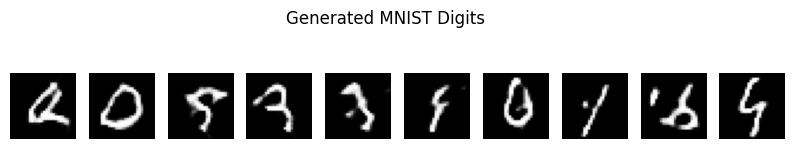

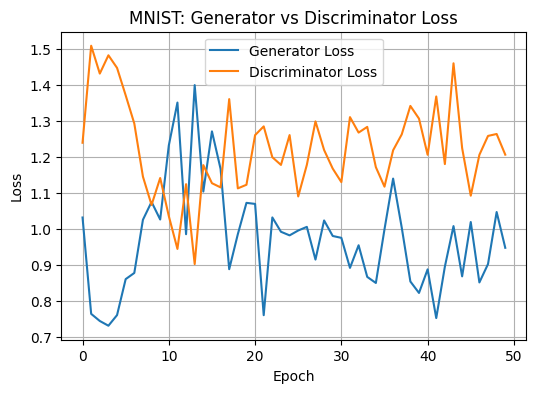

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train.astype("float32") - 127.5) / 127.5  # Normalize to [-1, 1]
x_train = np.expand_dims(x_train, axis=-1)

BUFFER_SIZE = 60000
BATCH_SIZE = 128
EPOCHS = 50
LATENT_DIM = 100

# Create tf.data pipeline
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# --- Generator ---
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(7*7*256, use_bias=False, input_shape=(LATENT_DIM,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

# --- Discriminator ---
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28, 28, 1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5,5), strides=(2,2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

# Create models
generator = build_generator()
discriminator = build_discriminator()

# Loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    return cross_entropy(tf.ones_like(real_output), real_output) + \
           cross_entropy(tf.zeros_like(fake_output), fake_output)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizers
gen_optimizer = tf.keras.optimizers.Adam(1e-4)
disc_optimizer = tf.keras.optimizers.Adam(1e-4)

# Training Step
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Train the model
gen_losses, disc_losses = [], []
for epoch in range(EPOCHS):
    for image_batch in dataset:
        g_loss, d_loss = train_step(image_batch)

    gen_losses.append(g_loss.numpy())
    disc_losses.append(d_loss.numpy())
    print(f'Epoch {epoch+1}/{EPOCHS} | Generator Loss: {g_loss:.4f} | Discriminator Loss: {d_loss:.4f}')

# Generate 10 digits
noise = tf.random.normal([10, LATENT_DIM])
generated_images = generator(noise, training=False)

# Plot 10 MNIST digits
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(generated_images[i, :, :, 0]*0.5 + 0.5, cmap='gray')  # Rescale [-1,1] → [0,1]
    plt.axis('off')
plt.suptitle("Generated MNIST Digits")
plt.show()

# Plot loss curves
plt.figure(figsize=(6, 4))
plt.plot(gen_losses, label='Generator Loss')
plt.plot(disc_losses, label='Discriminator Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("MNIST: Generator vs Discriminator Loss")
plt.grid(True)
plt.show()